# Conditional sampling evaluation

In [2]:
# Imports

import os
import torch

from jointformer.configs.dataset import DatasetConfig
from jointformer.configs.tokenizer import TokenizerConfig
from jointformer.configs.model import ModelConfig
from jointformer.configs.trainer import TrainerConfig

from jointformer.utils.datasets.auto import AutoDataset
from jointformer.utils.tokenizers.auto import AutoTokenizer
from jointformer.models.auto import AutoModel
from jointformer.trainers.trainer_fixed import Trainer

from jointformer.utils.runtime import set_seed

from jointformer.utils.properties.smiles.qed import QED
from jointformer.utils.properties.smiles.logp import LogP
from jointformer.utils.properties.smiles.sa import SA

from jointformer.utils.datasets.sequence import SequenceDataset

from jointformer.utils.transforms.scaler import Scaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# parralel processing // TODO: make this into a decorator

import multiprocessing as mp
import numpy as np
from tqdm import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
        

def apply_function_parallel(
    fn: Callable[[str], np.ndarray],
    data: List[str],
    num_workers: int = 4,
    desc: str = "Processing",
    chunksize: int = 10
) -> np.ndarray:
    """
    Apply a function that takes a string and returns a numpy array in parallel.

    The results from each invocation are assumed to have the same shape,
    and they will be stacked along a new first axis.

    Args:
        fn: Function that takes a string and returns a numpy array.
        data: List of strings to process.
        num_workers: Number of worker processes to use (default: 4).
        desc: Description for the tqdm progress bar.
        chunksize: Number of tasks to assign to each worker at a time (default: 10).

    Returns:
        A numpy array stacking the individual outputs along axis 0.
    """
    ctx = mp.get_context("spawn")
    with ctx.Pool(processes=num_workers) as pool:
        results = list(tqdm(pool.imap(fn, data, chunksize=chunksize), total=len(data), desc=desc))
    return np.stack(results, axis=0).squeeze(-1)

In [29]:
# unify oracles and validity checks

import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Crippen
from rdkit.Chem.QED import qed

from jointformer.utils.properties.smiles.sascorer import compute_sa_score

import multiprocessing

def smiles_to_mol(smiles):
    return Chem.MolFromSmiles(smiles)


def is_valid(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return False
        try:
            Chem.SanitizeMol(mol)
        except ValueError:
            return False
        return True
    except:
        return False

def get_qed(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        try:
            AllChem.Kekulize(mol, clearAromaticFlags=True)
        except:
            pass
        mol.UpdatePropertyCache(strict=False)
        return float(qed(mol))
    except:
        return float("nan")


def get_sa(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        try:
            AllChem.Kekulize(mol, clearAromaticFlags=True)
        except:
            pass
        mol.UpdatePropertyCache(strict=False)
        return float(compute_sa_score(mol))
    except:
        return float('nan')


def get_logp(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        try:
            AllChem.Kekulize(mol, clearAromaticFlags=True)
        except:
            pass
        mol.UpdatePropertyCache(strict=False)
        return float(Crippen.MolLogP(mol))
    except:
        return float('nan')


class QED:
    def __init__(self, **kwargs):
        pass 
    
    def __call__(self, smiles):
        return get_qed(smiles)


class LogP:
    def __init__(self, **kwargs):
        pass 
    
    def __call__(self, smiles):
        return get_logp(smiles)


class SA:
    def __init__(self, **kwargs):
        pass 
    
    def __call__(self, smiles):
        return get_sa(smiles)


Computing logp: 100%|██████████| 1273104/1273104 [03:19<00:00, 6381.93it/s]


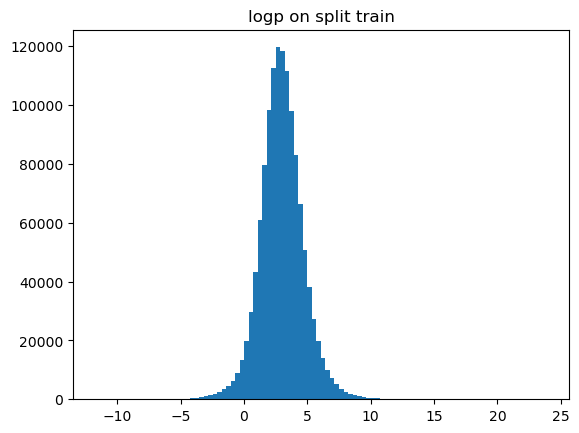

Dataset mean for target logp on split train: 2.995084721452451
Dataset std for target logp on split train: 1.7325130267016382


Computing logp: 100%|██████████| 79568/79568 [00:12<00:00, 6355.85it/s]


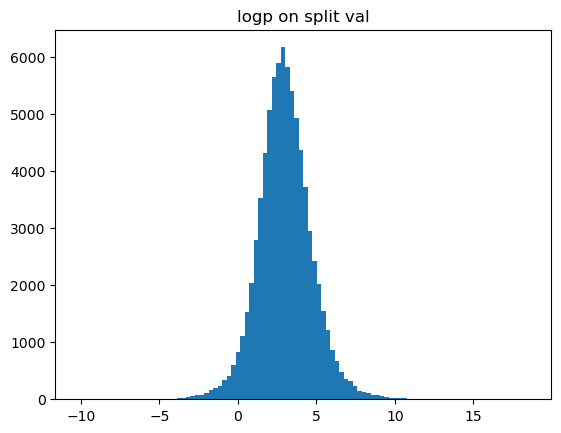

Dataset mean for target logp on split val: 2.989551278529059
Dataset std for target logp on split val: 1.7424291307177946


Computing logp: 100%|██████████| 238706/238706 [00:37<00:00, 6395.00it/s]


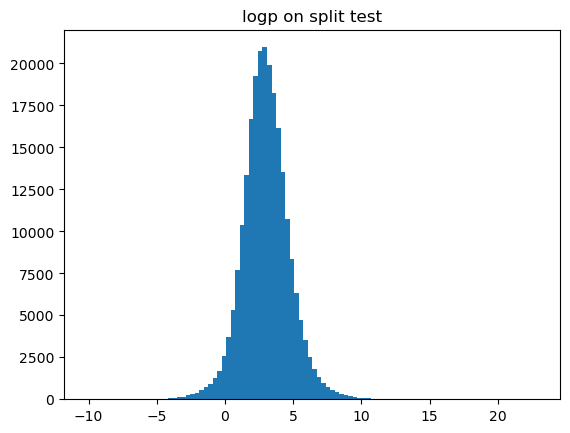

Dataset mean for target logp on split test: 3.0006065858838924
Dataset std for target logp on split test: 1.7337439683037925


Computing sa: 100%|██████████| 1273104/1273104 [11:09<00:00, 1900.79it/s]


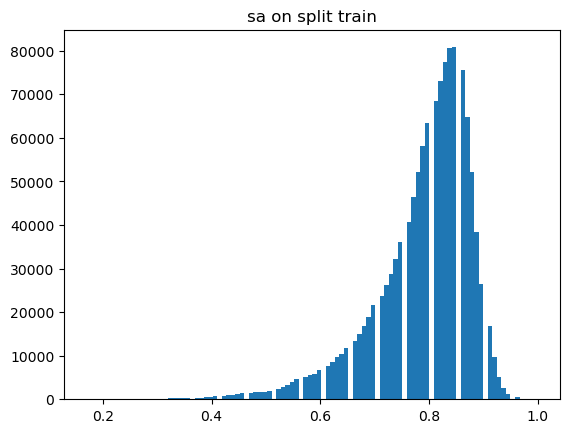

Dataset mean for target sa on split train: 0.7896584646658871
Dataset std for target sa on split train: 0.08999102410090047


Computing sa: 100%|██████████| 79568/79568 [00:41<00:00, 1912.42it/s]


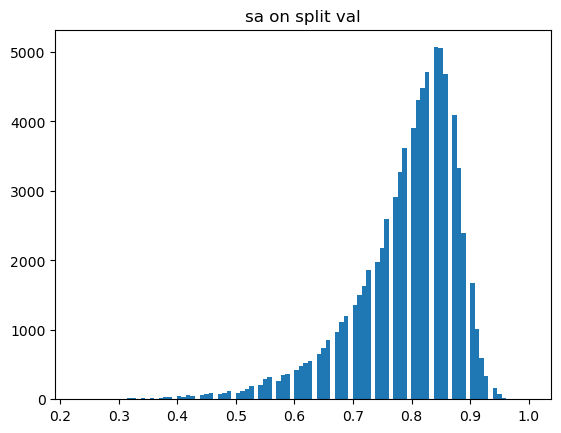

Dataset mean for target sa on split val: 0.7894201186406595
Dataset std for target sa on split val: 0.0901510816800199


Computing sa: 100%|██████████| 238706/238706 [02:04<00:00, 1917.89it/s]


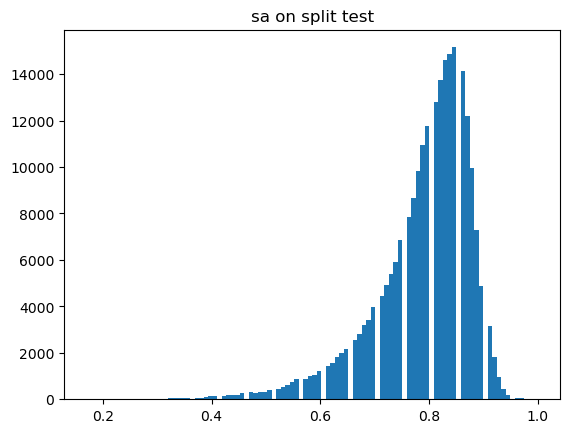

Dataset mean for target sa on split test: 0.7896882357376858
Dataset std for target sa on split test: 0.09007037983768094


In [33]:
# Paths

for TARGET_NAME in ['logp', 'sa']:

    DATA_DIR = '/lustre/groups/aih/jointformer/icml25/data'
    PATH_TO_DATASET_CONFIG   = 'configs/datasets/guacamol/config.json'

    # Oracles
    _dtype = 'np'
    _verbose = False
    if TARGET_NAME == 'qed':
        oracle = get_qed    
    elif TARGET_NAME == 'logp':
        oracle = get_logp
    elif TARGET_NAME == 'sa':
        oracle = get_sa
    else:
        raise ValueError(f"Unknown target name: {TARGET_NAME}")

    # Configs
    dataset_config = DatasetConfig.from_config_file(PATH_TO_DATASET_CONFIG)

    # Extract
    for split in ['train', 'val', 'test']:
        
        dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split=split)
        
        with multiprocessing.Pool(processes=4) as pool:
            properties = list(tqdm(pool.imap(oracle, dataset.data), total=len(dataset.data), desc=f"Computing {TARGET_NAME}"))
            
        properties = np.array(properties)
        if len(properties.shape) == 1:
            properties = properties[:, None]
        elif len(properties.shape) == 3:
            properties = properties.squeeze(-1)
        else:
            pass
        assert len(properties.shape) == 2 and properties.shape[0] == len(dataset.data) and properties.shape[1] == 1 and not np.isnan(properties).any()
        
        # plot a histogram of the properties
        plt.hist(properties, bins=100)
        plt.title(f"{TARGET_NAME} on split {split}")
        plt.show()

        print(f"Dataset mean for target {TARGET_NAME} on split {split}:", properties.mean())
        print(f"Dataset std for target {TARGET_NAME} on split {split}:", properties.std())

        _path = os.path.join(DATA_DIR, f'guacamol_{TARGET_NAME}/{split}.npz')
        if not os.path.exists(_path):
            os.makedirs(os.path.dirname(_path), exist_ok=True)
        np.savez(_path, sequence=dataset.data, properties=properties)

In [34]:
properties

array([[0.8 ],
       [0.63],
       [0.87],
       ...,
       [0.88],
       [0.85],
       [0.76]])

## Fine-tune

In [3]:
# Set logging

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# set seed
SEED = 1337

set_seed(SEED)

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# Configs

TARGET_NAME = 'sa'

OUT_DIR = f'/lustre/groups/aih/jointformer/icml25/results/conditional_sampling/{TARGET_NAME}'

DATA_DIR = '/lustre/groups/aih/jointformer/icml25/data'
PATH_TO_DATASET_CONFIG   = f'configs/datasets/guacamol_{TARGET_NAME}/config.json'
PATH_TO_TOKENIZER_CONFIG = 'configs/tokenizers/smiles_separate_task_token/config.json'
PATH_TO_MODEL_CONFIG = 'configs/models/jointformer_prediction_deep/config.json'

#hparams
MAX_EPOCH = '2'
DECAY_LR = 'true'
BATCH_SIZE = '256'
LEARNING_RATE = '5e-4'
WEIGHT_DECAY = '1e-1'
POOLER_DROPOUT = '0.0'

PATH_TO_MODEL_CKPT = f'/lustre/groups/aih/jointformer/results_icml25_rebuttal/conditional_sampling/{TARGET_NAME}/llama_backbone/max_epochs_{MAX_EPOCH}/decay_lr_{DECAY_LR}/batch_size_{BATCH_SIZE}/learning_rate_{LEARNING_RATE}/weight_decay_{WEIGHT_DECAY}/pooler_dropout_{POOLER_DROPOUT}/seed_0/ckpt.pt'

# check if paths exist
assert os.path.exists(PATH_TO_MODEL_CKPT), f'Path to model checkpoint does not exist: {PATH_TO_MODEL_CKPT}'


In [5]:
# Load dataset

dataset_config = DatasetConfig.from_config_file(PATH_TO_DATASET_CONFIG)

train_dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split='train')
val_dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split='val')
test_dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split='test')

Converting target to float32.
Converting target to float32.
Converting target to float32.


In [6]:
# Load tokenizer

tokenizer_config = TokenizerConfig.from_config_file(PATH_TO_TOKENIZER_CONFIG)
tokenizer = AutoTokenizer.from_config(tokenizer_config)

In [7]:
# Load model

model_config = ModelConfig.from_config_file(PATH_TO_MODEL_CONFIG)
model = AutoModel.from_config(model_config, downstream_task="regression", num_tasks=1)
model.load_pretrained(PATH_TO_MODEL_CKPT)
model.to(device)
model.eval()

JointformerForDownstreamPredictionDeep(
  (token_embedding): Embedding(596, 256)
  (layers): ModuleList(
    (0-7): 8 x TransformerLayer(
      (attention_layer): Attention(
        (qkv): Linear(in_features=256, out_features=768, bias=False)
        (out): Linear(in_features=256, out_features=256, bias=False)
        (relative_embedding): RotaryPositionalEmbedding()
      )
      (feed_forward): FeedForward(
        (w1): Linear(in_features=256, out_features=1024, bias=False)
        (w3): Linear(in_features=256, out_features=1024, bias=False)
        (w2): Linear(in_features=1024, out_features=256, bias=False)
      )
      (attention_layer_normalization): RMSNorm()
      (feed_forward_normalization): RMSNorm()
    )
  )
  (layer_norm): RMSNorm()
  (lm_head): Linear(in_features=256, out_features=596, bias=False)
  (mlm_head): Linear(in_features=256, out_features=596, bias=False)
  (physchem_head): RegressionHead(
    (net): Sequential(
      (0): Linear(in_features=256, out_features=

In [ ]:
import numpy as np

from tqdm.auto import tqdm

from jointformer.utils.chemistry import is_valid

In [ ]:
BATCH_SIZE = 256
TEMPERATURE = 1.0
GENERATION_K = 10
K = BATCH_SIZE * 4
NUM_SAMPLES = 64

TARGET_NAME = 'sa'
TARGET_PROPERTY_VALUE = 0.7

BEST_OF_K = True


In [ ]:
### Best-ok-K sampling

# Initialize generated samples
generated_samples = []

# Get target property value
if hasattr(train_dataset, 'target_transform'):
    target_property_value = train_dataset.target_transform(TARGET_PROPERTY_VALUE)
else:
    target_property_value = TARGET_PROPERTY_VALUE

# Generate samples
for num_sample in tqdm(range(NUM_SAMPLES)):

    # 1. Generate K-many unique SMILES 
    smiles = []
    while len(smiles) < K:
        _smiles_idx = model.generate(
            tokenizer=tokenizer,
            batch_size=BATCH_SIZE,
            temperature=TEMPERATURE,
            top_k=GENERATION_K,
            device=device
            ).detach().cpu()
        _smiles = tokenizer.decode(_smiles_idx)
        smiles.extend(_smiles)
        smiles = list(set(smiles))
    smiles = smiles[:K]

    # 2. Compute properties with a surrogate model
    properties = []
    for i in range(0, len(smiles), BATCH_SIZE):
        _batch = smiles[i:i+BATCH_SIZE]
        _inputs = tokenizer(_batch, task='prediction')
        _inputs.to(device)
        _properties = model.predict(**_inputs).detach().cpu()
        properties.extend(_properties.numpy()) 
    
    # 3. Transform properties to scores    
    scores = np.array(properties)
    scores = np.abs(scores - target_property_value)

    # 4. Sort by scores
    sorted_indices = np.argsort(scores.flatten())
    smiles = [smiles[i] for i in sorted_indices]

    # 5. Add the best smiles to generated samples
    if BEST_OF_K:
        # select the best smiles
        for _best_idx in range(len(smiles)):
            _best_smiles = smiles[_best_idx]
            if _best_smiles not in generated_samples:
                generated_samples.append(_best_smiles)
                break
    else:
        # select, if score is smaller than epsilon
        _epsilon = 0.005
        _samples = [smiles[i] for i in range(len(smiles)) if scores[i] < _epsilon]
        if len(_samples) > 0:
            generated_samples.extend(_samples)  
        generated_samples = list(set(generated_samples))  

100%|██████████| 64/64 [22:02<00:00, 20.66s/it]


In [ ]:
### Evaluate generated samples

# Define oracle

if TARGET_NAME == 'qed':
    oracle = QED(dtype='np', verbose=False)
elif TARGET_NAME == 'logp':
    oracle = LogP(dtype='np', verbose=False)
elif TARGET_NAME == 'sa':
    oracle = SA(dtype='np', verbose=False)
else:
    raise ValueError(f"Unknown target name: {TARGET_NAME}")

# Filter valid samples
valid_samples = [sample for sample in generated_samples if is_valid(sample)]

# Compute properties
oracle_properties = oracle(valid_samples)

# Calculate metrics

mad = np.mean(np.abs(train_dataset.target_transform(oracle_properties) - train_dataset.target_transform(TARGET_PROPERTY_VALUE)))
print(f'MAD: {mad:.3f}')
std = np.std(oracle_properties)
print(f'STD: {std:.3f}')
validity = len(valid_samples) / len(generated_samples)
print(f'Validity: {validity:.3f}')
print('---*---')
mae = np.mean(np.abs(oracle_properties - TARGET_PROPERTY_VALUE))
print(f'MAE: {mae:.3f}')


MAD: 0.836
STD: 0.112
Validity: 1.000
---*---
MAE: 0.677


In [ ]:
oracle_properties

array([[3.4122899],
       [3.397034 ],
       [3.373155 ],
       [3.7671711],
       [3.4728928],
       [3.5324028],
       [3.4994059],
       [3.429823 ],
       [3.572391 ],
       [3.7795236],
       [5.341826 ],
       [3.5306134],
       [3.39616  ],
       [3.299311 ],
       [3.327442 ],
       [3.6105807],
       [3.3180609],
       [3.4575677],
       [3.5187552],
       [3.7830558],
       [3.3723736],
       [3.4237368],
       [3.6101234],
       [3.4551935],
       [3.4074912],
       [3.4582317],
       [3.5209086],
       [3.7737691],
       [3.6801121],
       [3.5038803],
       [3.9969177],
       [3.6283746],
       [3.5416377],
       [3.4621253],
       [3.4263709],
       [3.5331814],
       [3.2201395],
       [3.4046137],
       [3.3145757],
       [3.473243 ],
       [3.488173 ],
       [3.3659184],
       [3.4335473],
       [3.475624 ],
       [3.3146908],
       [3.3627005],
       [3.423538 ],
       [3.3893688],
       [3.4208577],
       [3.537182 ],


In [ ]:
# ZINC dataset and MOSES benchmark

2+2

In [7]:
from jointformer.utils.properties.auto import AutoTarget
import argparse
import multiprocessing as mp
import numpy as np
import os
import math

from jointformer.utils.chemistry import is_valid


In [16]:
split = 'train'
DATA_PATH = f'/lustre/groups/aih/jointformer/icml25/data/moses/{split}.txt'
TARGET = 'physchem'
NUM_WORKERS = 4

oracle = AutoTarget.from_target_label(TARGET, dtype='np')


In [17]:
with open(DATA_PATH) as f:
    data = f.readlines()
data = data[1:]  # Skip header
# remove part after comma 
data = [line.split(',')[0] for line in data]

In [18]:
print(f"Number of SMILES in {split} set: {len(data)}")

Number of SMILES in train set: 1584663


In [19]:
valid_data = [smiles for smiles in data if is_valid(smiles)]

In [20]:
len(data), len(valid_data)

(1584663, 1584663)

In [21]:
def worker(oracle, chunk, id, ret_dict):
    ret_dict[id] = oracle(chunk)
    
chunk_size = math.ceil(len(data) / 4)
manager = mp.Manager()
ret_dict = manager.dict()
processes = []
for i in range(4):
    chunk = data[i*chunk_size: i*chunk_size + chunk_size]
    p = mp.Process(target=worker, args=(oracle, chunk, i, ret_dict))
    p.start()
    processes.append(p)
for p in processes:
    p.join()

ret = np.concatenate([v for _, v in sorted(ret_dict.items())], axis=0)


Calculating target data: 100%|██████████| 396166/396166 [2:55:03<00:00, 37.72it/s]


In [22]:
assert len(ret) == len(data)
assert len(ret.shape) == 2
assert ret.shape[0] == len(data)
assert ret.shape[1] == 200
assert not np.isnan(ret).any()

# Save results
print(f"Saving results to {DATA_PATH} of shape {ret.shape}")
np.savez(f'/lustre/groups/aih/jointformer/icml25/data/moses/{split}.npz', sequence=data, properties=ret)

Saving results to /lustre/groups/aih/jointformer/icml25/data/moses/train.txt of shape (1584663, 200)


In [9]:
model = model.to_guacamole_generator(tokenizer, 16, 1.0, 10, device)

In [11]:
model.generate(number_samples=16)

Generating samples: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


['CCc1ccc(-n2c(C)nc3c(-c4ccccc4NC(=O)Cc4ccccc4)nccc32)cc1',
 'Cc1cccc(C)c1NC(=O)Cn1c(C(=O)O)cc2ccccc21',
 'COc1ccc2c(c1)C(CC(C)=O)N(c1cccc(F)c1)O2',
 'Nc1ncnc2c1ncn2CC#CCCCC(C=O)NC(=O)C1NC2c3c(ccc(CO)c3O)C(=O)N2C1',
 'Clc1ccc(CN2CCN(c3ccccc3Cl)CC2)c(Cl)c1',
 'O=C(CCCC1CCCCC1)NCCCCCNc1c2c(nc3cc(Cl)ccc13)CCCC2',
 'Cc1cnccc1N1CCN(S(=O)(=O)c2c[nH]c3ccc(Br)cc23)CC1',
 'CN1C2CCC1C1C(=O)N(CC34CC5CC(CC(CCOC(=O)c6ccccc6)(C5)C3)C4)C(=O)C21',
 'CC(C)(C)c1ccc(-c2nnc(NCCCCCC(=O)NO)s2)cc1',
 'CC(C)c1cc(-c2nc(-c3cccc(Cl)c3)no2)cc(C(C)C)c1O',
 'NCC1(O)COc2ccc(-c3coc4cc(O)ccc4c3=O)cc2O1',
 'CN(C)Cc1cc(Nc2cc(C(F)(F)F)nc(-c3ccccc3)n2)ccc1O',
 'O=C(c1cccs1)N1CCC(N2CC3c4cccc(=O)n4CC(C)(C2)C3)C1',
 'O=C(NN=CC1CC=CCC1)c1cc2ccccc2o1',
 'COc1cc(NC2CC2)n2ncnc2n1',
 'Cc1nnc(-c2ccncc2)nc1N1CCc2ccccc2C1']